# Introduction

Statistics is an important discipline. With the emergence of modern data science it became even more important. So far, I encountered plenty education metarials about frequentist statistics. The deterministic nature of the frequent statistics is appealing but the books I read in this summer (summer 2024) highly encouraged me to learn and embrace the Bayesian thinking.

Bayesian Statistics combines the prior knowledge and the observations like we do in our daily life. As a result of that, it produces the probability of outcomes. It is not deterministic which makes it more realistic.  

This notebook is prepared from my notes. I won't delve deep into the mathematics behind the concept. Rather I focus on the programming aspect. During my preparation I utilized from these books:

1. Bayesian Analysis with Python - Third Edition: A practical guide to probabilistic modeling ([Link](https://www.amazon.com/Bayesian-Analysis-Python-Practical-probabilistic/dp/1805127160))

2. An Introduction to Bayesian Thinking ([Link](https://statswithr.github.io/book/))

Finally, I highly recommend readers to refer to the second reference to better understand the concept and follow the examples that I solved in this notebook. Although the book is written in R, this should not pose a problem for Python users. One of my main goals in writing this notebook is to translate and solve the examples in Python, making it accessible for those familiar with the Python programming language.


In [1]:
# !pip install pymc
import pymc as pm
from scipy import stats
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
!pip install pingouin
import pingouin as pg

az.style.use('arviz-darkgrid')

# 1.Bayesian Modeling with Conjugate Families

## 1.1. A Statistical Model with Beta Prior

In Bayesian statistics, we need to determine a prior distribution beforehand. Depending on our knowledge it could be an *informative one* (strongly reflects our understanding of the event) or an *uninformative one* (doesn't influence the posterior distribution significantly).

When choosing priors, it is always a good practise to select the conjugate ones because if we do so, the posterior distribution is calculated much easier. Three conjugate families are:

* Beta - Binom pair
* Normal - Normal pair
* Gamma - Poission pair

If we want to choose an uninformative prior for a sequence of Bernoulli trials, a Beta distribution with parameters $α = β = 1$ is a suitable choice. Let's see how it looks like:

<Axes: ylabel='Density'>

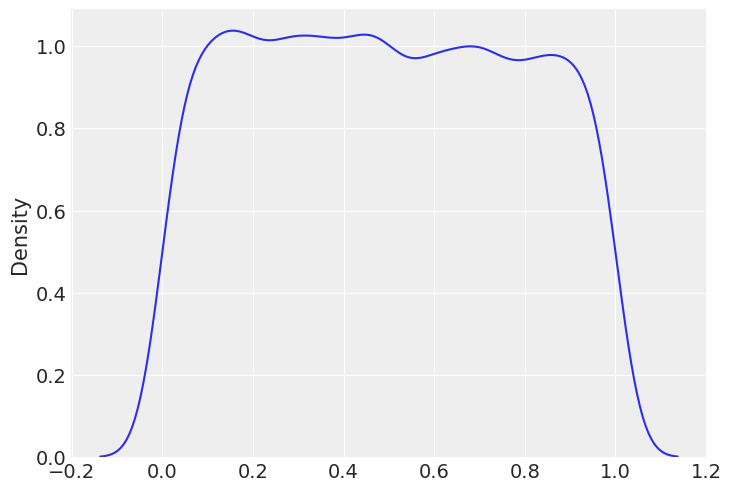

In [2]:
sns.kdeplot((stats.beta.rvs(a = 1, b = 1, size=10000)))

A Bayesian model looking using `Beta-Binom family` looks like this:

In [3]:
with pm.Model():
  theta = pm.Beta('theta', alpha = 1, beta = 1)
  likelihood = pm.Bernoulli('likelihood', p = theta, observed = [1, 1, 0, 1, 1])
  trace = pm.sample()

Output()

Output()

Note that the posterior distribution is maximized around $\theta = 0.8$ since the observations yield an expected value of 0.8.

<Axes: title={'center': 'theta'}>

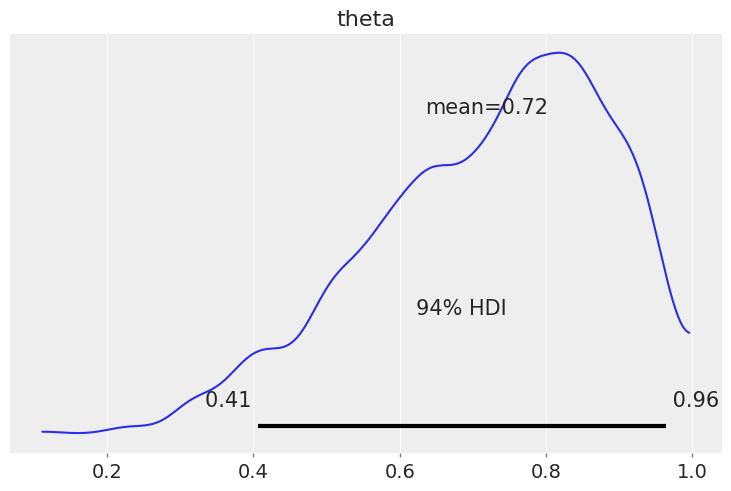

In [4]:
az.plot_posterior(trace,var_names = ["theta"])

### 1.1.1. The Impact of the Number of Data Points

What if we had more data points? Will the prior distribution affects the posterior one at the same extent? Let's try.

In [5]:
observed = 10*[1, 1, 0, 1, 1]

with pm.Model():
  theta = pm.Beta('theta', alpha = 1, beta = 1)
  likelihood = pm.Bernoulli('likelihood', p = theta, observed = observed)
  trace = pm.sample(1000)

Output()

Output()

<Axes: title={'center': 'theta'}>

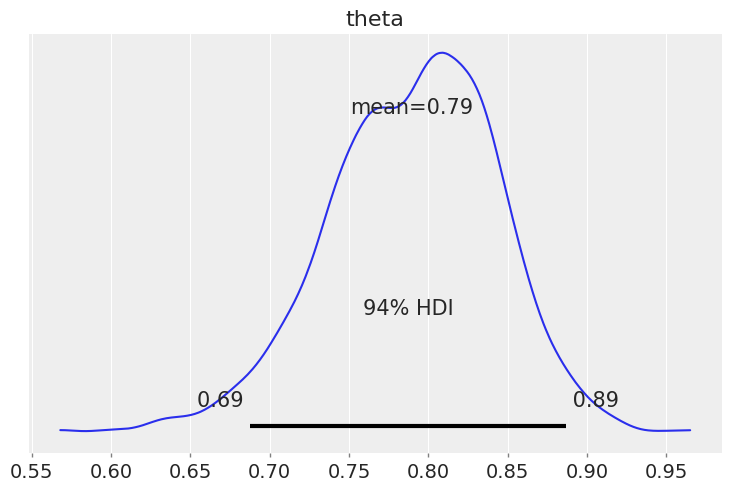

In [6]:
az.plot_posterior(trace,var_names = ["theta"])

What can we conclude from this? As the number of observations increases, the impact of the prior distribution decreases. It's actually a great thing because as we have more and more data, the prior selection would be less of a concern. Let's try one more time. This time we will select a prior which is very different from the observations (the plot below).

<Axes: ylabel='Density'>

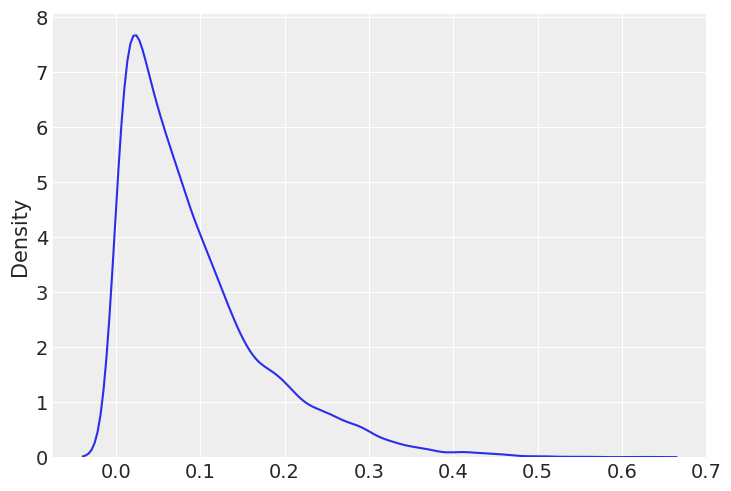

In [7]:
sns.kdeplot((stats.beta.rvs(a = 1, b = 10, size=10000)))

When we have enough data, even this kind of a skewed distribution has almost no effect on the posterior.

Output()

Output()

<Axes: title={'center': 'theta'}>

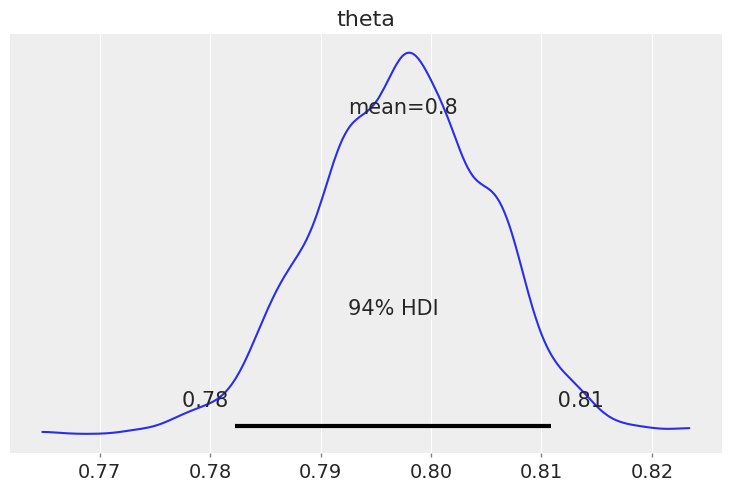

In [8]:
observed = 500*[1, 1, 0, 1, 1]

with pm.Model():
  theta = pm.Beta('theta', alpha = 1, beta = 10)
  likelihood = pm.Bernoulli('likelihood', p = theta, observed = observed)
  trace = pm.sample(1000)

az.plot_posterior(trace,var_names = ["theta"])

### 1.1.2. Credible Interval

Credible interval and confidence interval are similar but they tell us different things. For example a 95% confidence interval indicates that if we repeat the same experiment over and over again, 95% of the experiment results lie in proposed range. On the other hand, 95% credible interval indicates that there is a 95% probability that the true value of the parameter lies within the specified range.

High Density Interval (HDI) is a form of credible interval. The wikipedia definition looks like [this](https://en.wikipedia.org/wiki/Credible_interval):

>Credible regions are not unique; any given probability distribution has an infinite number of credible regions of probability
$α$. For example, in the univariate case, there are multiple definitions for a suitable interval or region:

>The smallest interval, sometimes called the highest density interval (HDI). This interval will necessarily include the median whenever
${\displaystyle \alpha \geq 0.5}$. Besides, when the distribution is unimodal, this interval will include the mode.

In [9]:
az.summary(trace,kind = "stats").round(2)

,mean,sd,hdi_3%,hdi_97%
theta,0.8,0.01,0.78,0.81


From this table, we can conclude that there is 94% probablility of real $\theta$ lies in $(0.78,0.81)$.

## 1.2. A Statistical Model with Gaussian Prior


Let' say now we want to deal with an event having continuos random variables:

<Axes: ylabel='Density'>

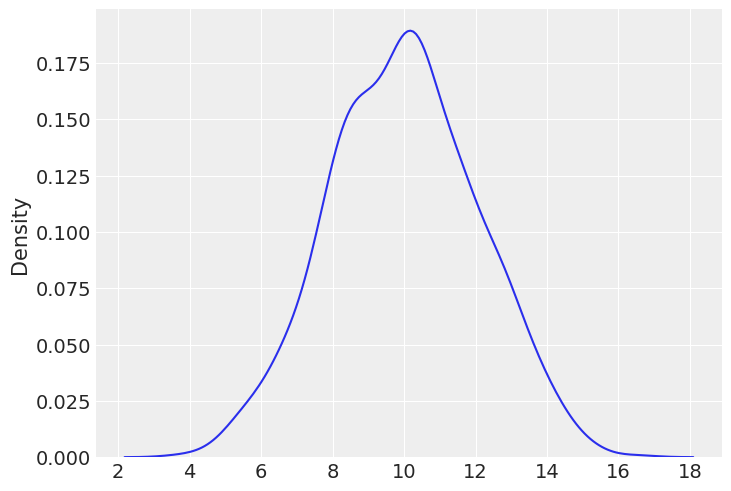

In [ ]:
data = np.random.normal(loc = 10,scale = 2,size = 1000)
sns.kdeplot(data)

We know that that the real value of $\theta$ lies between 0 and 30 but we have no clue about the most probable value of it. We can use an uniform prior then.

<Axes: ylabel='Density'>

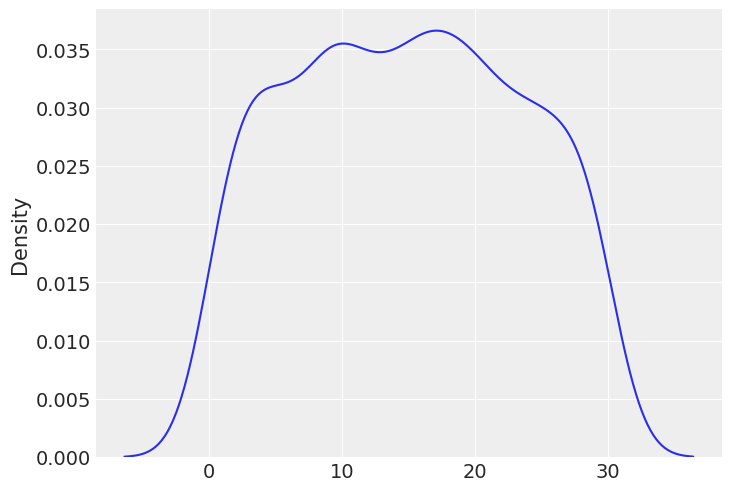

In [ ]:
prior = np.random.uniform(low = 0,high = 30,size = 1000)
sns.kdeplot(prior)

Here is the Bayesian model. Note that since we also have no clue about the variability of $\theta$, we have to choose a relatively large standard deviation ($\sigma$ = 10). In later parts of this kernel, we will select the varibilility more professionally.

In [ ]:
with pm.Model() as model_g:
  mu = pm.Uniform("prior",lower = 0, upper = 30)
  sigma = pm.HalfNormal('sigma', sigma = 10)
  likwlihood = pm.Normal("likelihood", mu = mu, sigma = sigma, observed = data)
  trace = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'prior'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

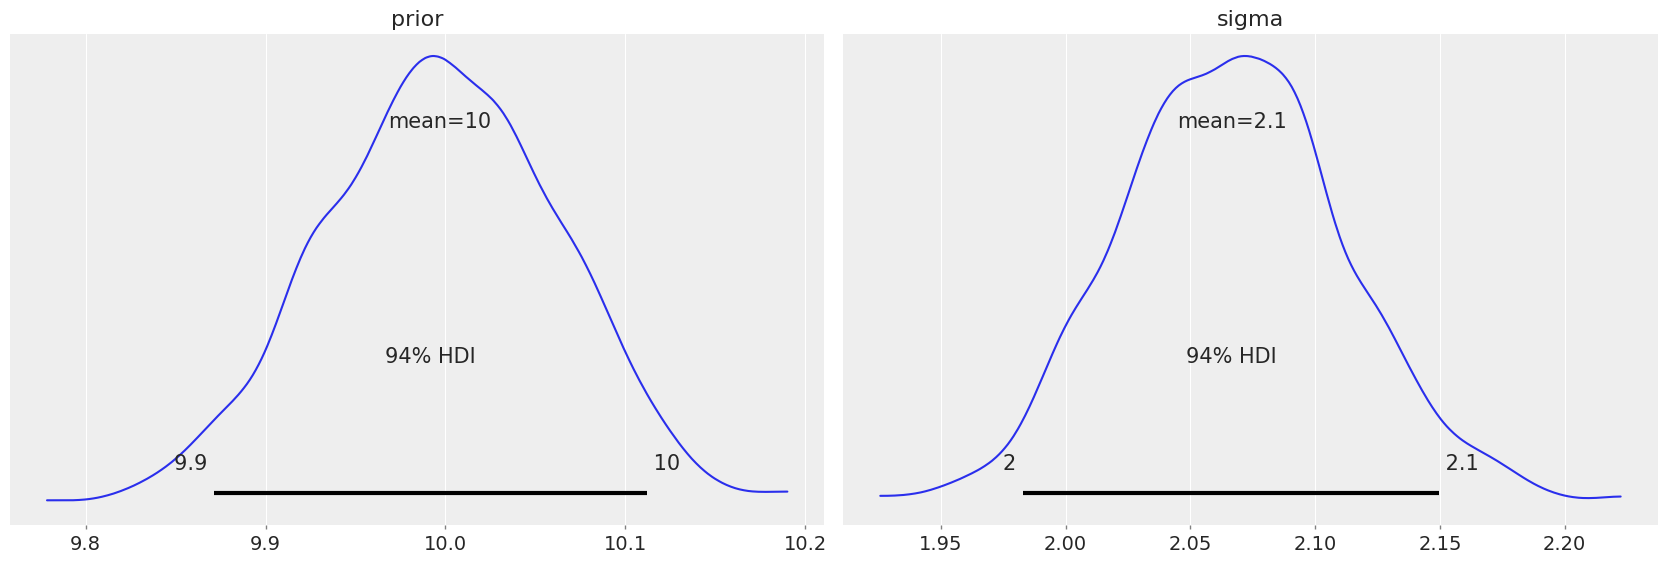

In [ ]:
az.plot_posterior(trace)

In [ ]:
az.summary(trace,kind = "stats").round(2)

,mean,sd,hdi_3%,hdi_97%
prior,10.00,0.06,9.87,10.11
sigma,2.07,0.04,1.98,2.15


## 1.2.1. A Statistical Model with T-Distributed Prior

T-distribution is similar to the normal distribution but it has fatter tails:



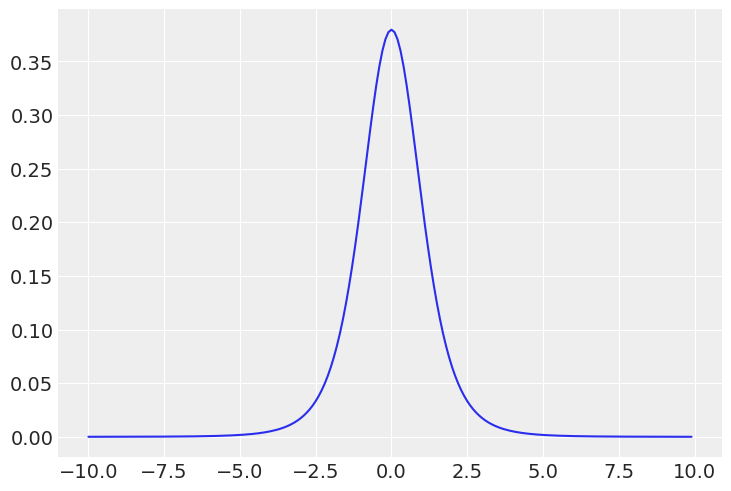

In [10]:
x = np.arange(-10,10,0.1)
y = stats.t.pdf(x,df = 5)
plt.plot(x,y)

The degree of freedom (dof) parameter changes the shape of the t-distribution. As dof reaches infinity we get a normal distribution.

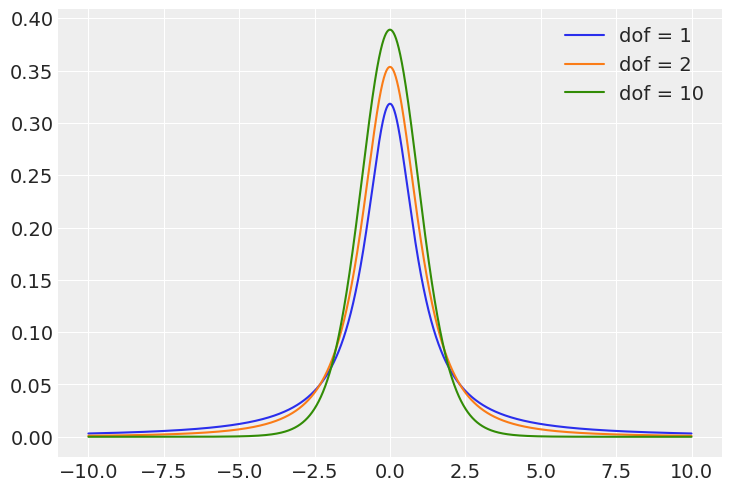

In [11]:
x = np.arange(-10,10,0.001)
y1 = stats.t.pdf(x,df = 1)
y2 = stats.t.pdf(x,df = 2)
y3 = stats.t.pdf(x,df = 10)

plt.figure()
plt.plot(x,y1, label = 'dof = 1')
plt.plot(x,y2, label = 'dof = 2')
plt.plot(x,y3, label = 'dof = 10')
plt.legend()
plt.show()

Tails of the t-distribution makes the model more robust. To get the most robust statistical model, `Cauchy distribution` (t-distribution having dof = 1) is used.

In [12]:
with pm.Model() as model_t:
  mu = pm.Uniform("mu",lower = 0, upper = 30)
  sigma = pm.HalfNormal('sigma', sigma = 10)
  y = pm.StudentT("y", mu = mu, sigma = sigma, nu = 1, observed = data)
  trace = pm.sample()

NameError: name 'data' is not defined

In [ ]:
az.plot_posterior(trace);

In [ ]:
az.summary(trace,kind = "stats").round(2)

## 1.3. A Statistical Model with Gamma Prior

Let's say we want to model, the number of car crashes per day in a traffic way. Say it's expected value is 10. We know that it is around 5 but we have no idea about its variability. The parameters of gamma distribution is $\alpha$ and $\beta$. Their relationship with mean and standard deviation can be shown as:

$\alpha = \frac {\mu^2} {\sigma^2}$

$\beta = \frac {\mu} {\sigma^2}$

$scale = \frac 1 β $

<Axes: ylabel='Density'>

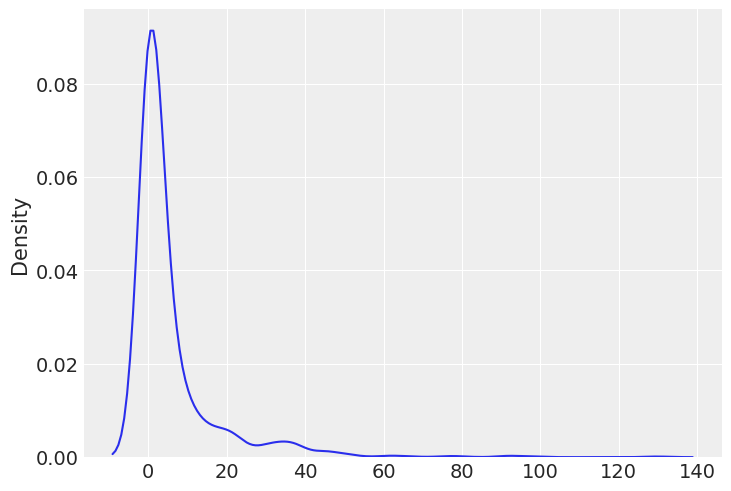

In [13]:
mu = 5
sigma = 10

alpha = np.square(mu) / np.square(sigma)
beta = mu / np.square(sigma)

sns.kdeplot(stats.gamma.rvs(a = alpha, scale = 1/beta, size = 1000))

The `gamma-poisson` model having that prior is:

Output()

Output()

<Axes: title={'center': 'prior_mu'}>

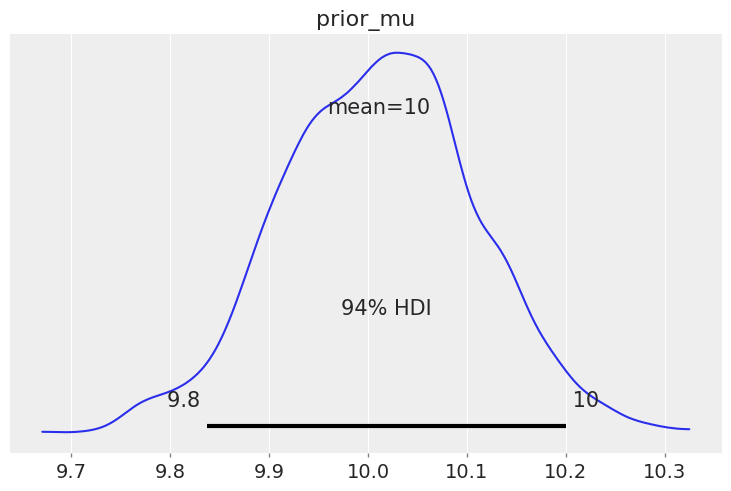

In [14]:
observed_data = np.random.poisson(lam = 10,size = 1000)
with pm.Model() as gamme_poisson_model:

  prior_mu = pm.Gamma("prior_mu", mu = 5, sigma = 10)
  likelihood = pm.Poisson("likelihood", mu = prior_mu, observed = observed_data)
  trace = pm.sample()

pm.plot_posterior(trace)

## 1.2. Modeling Success-Failure Events

### 1.2.1. Question 1

Let's say we are testing the effectiveness of a treatment. 15 out 20 samples are in the success condition.



#### 1.2.1.1 Frequentist Approach (Q1)

* $H_0:$ The treatment is not effective. Thus, the probability of a randomly selected person from the group being healthy (success) is equal to 50%. (P = 0.5)

* $H_1$: The treatment is effective. Thus, the probability of a randomly selected person from the group being healthy (success) is greater than 50%. (P > 0.5)

In [15]:
n = 20
k = 15
p = 0.5


result = stats.binomtest(k, n, p,alternative='greater')
result

BinomTestResult(k=15, n=20, alternative='greater', statistic=0.75, pvalue=0.020694732666015625)

In [16]:
pg.bayesfactor_binom(k = k, n = n, p = 0.5)

3.220600520910117

There is enough evidence that rejects $H_0$. For bayes factor interpretation, refer to this [link](https://www.researchgate.net/profile/Varadharajan-Jayakumar/publication/346083548/figure/tbl1/AS:960709718454273@1606062454646/Jeffreys-Interpretation-of-Bayes-Factor-BF-10-82-83.png).


Normally all the experiments are done with the control group to avoid biases. Let's say the control group also consists of 20 people and 11 of them are healthy (sucess) condition:

In [17]:
x = [1]*15 + [0]*5
y = [1]*11 + [0]*9
pg.compute_effsize(x = x,y = y,eftype = 'cohen')

0.41798641566223277

Effect size is a measure of the practical applicability of the test result in real life. For effect size interpretiton, refer to this [link](https://www.grupocomunicar.com/wp/escuela-de-autores/wp-content/uploads/sites/2/2020/06/10.4135_9781483381411-table13.jpg). From the result, we understand that though the treatment is effective, it's effect is medium in real life.

#### 1.2.1.2. Bayesian Framework (Q1)

The treatment is effective according to the frequentist approach. Let's analyze the same problem using Bayesian framework.

Output()

Output()

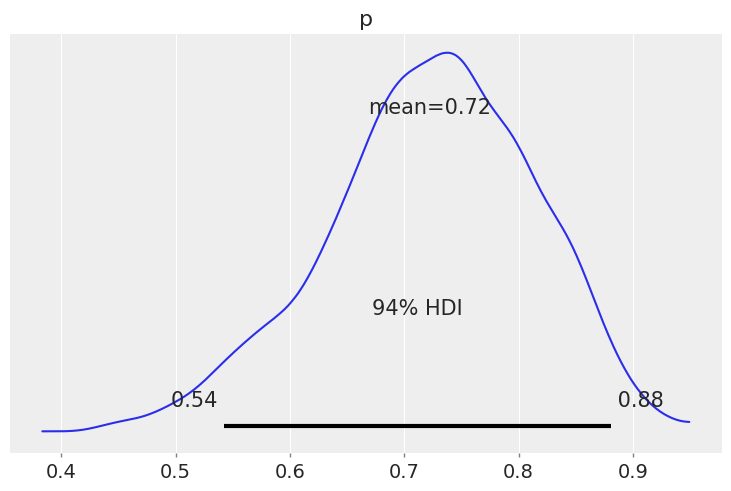

In [18]:
n = 20
k = 15

with pm.Model() as model:
    p = pm.Beta('p', alpha=1, beta=1)
    likelihood = pm.Binomial('likelihood', n=n, p=p, observed=k)
    trace = pm.sample()

p_values = trace.posterior['p'].values.flatten()
pm.plot_posterior(trace)
plt.show()

In [19]:
kde_func = gaussian_kde(p_values)
for i in np.arange(0.1,1,0.1):
  print(f"p: {np.round(i,2)}  {kde_func(i)[0]}")

p: 0.1  7.22674519257775e-46
p: 0.2  9.443072161396472e-21
p: 0.3  2.005633246620023e-06
p: 0.4  0.02291904408298085
p: 0.5  0.3696551419968567
p: 0.6  1.500331915720059
p: 0.7  4.084281693683706
p: 0.8  3.279835482586781
p: 0.9  0.6005430091255849


From the results we found that the likelihood of the real probability is maximized when $p ≈ 0.75$. Also 0.5 is not in HDI. Therefore we can conclude that the treatment is effective.

### 1.2.2. Question 2

#### 1.2.2.1. Frequentist Approach (Q2)

Let's say we are investigating a topic having 20% success rate. We conducted our experiments out of 20 samples. 8 of them in the success condition. We hypothesized that the real probability actually greater than 0.2.

* $H_0:$ P = 0.2
* $H_1:$ P > 0.2

In [20]:
stats.binomtest(k = 8, n = 20, p = 0.2,alternative = "greater")

BinomTestResult(k=8, n=20, alternative='greater', statistic=0.4, pvalue=0.03214266308087516)

According to the frequentist approach, we reject $H_0$ (which is true). What if we designed the $H_0$ like the following:

* $H_0$: P = 0.3
* $H_1$: P > 0.3

In [21]:
stats.binomtest(k = 8, n = 20, p = 0.3,alternative = "greater")

BinomTestResult(k=8, n=20, alternative='greater', statistic=0.4, pvalue=0.22772820258183926)

This time we couldn't reject the $H_0$ even $H_1$ is actually the case. Therefore we can conclude that **the frequentist approach is sensitive to how we constructed the $H_0$.**

#### 1.2.2.2 Bayesian Framework (Q2)

Let's try the Bayesian approach this time:

In [22]:
with pm.Model() as model:
  p = pm.Beta("p", alpha = 1, beta = 1)
  likelihood = pm.Binomial("likelihood", p = p, n = 20, observed = 8)
  trace = pm.sample()

Output()

Output()

<Axes: title={'center': 'p'}>

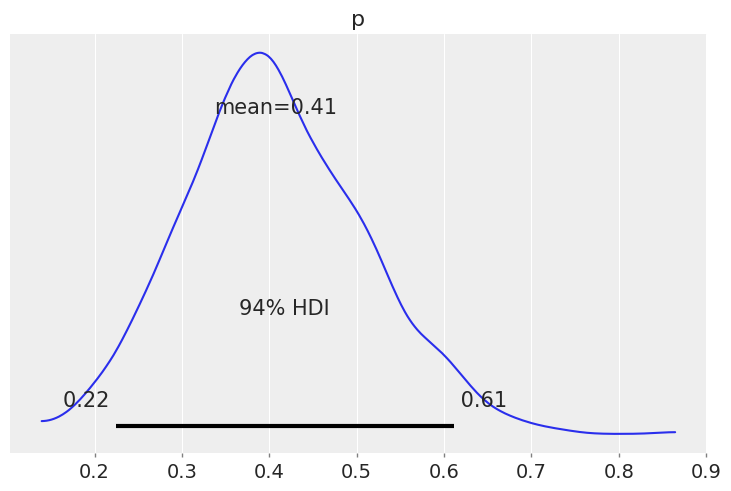

In [23]:
az.plot_posterior(trace)

When we have no idea about the topic, the results are similar. We are confident that the real $p$ is not 0.2, but it is not the case for $p = 0.3$. Now what if we were an expert on the same treatment

BURASI DÜZENLENECEK.

## 1.3. Bayesian Update for Probabilities

How to use posterior distribution as the next prior distribution?

### 1.3.1. Beta-Binom Conjugate Family

Let's say we conducted an experiment out of 20 people and realized that only the 4 of them are positive. We are assuming that we have no prior information therefore we set $\alpha = β = 1$. Then the corresponding Bayesian model looks something like this:

Output()

Output()

<Axes: title={'center': 'prior'}>

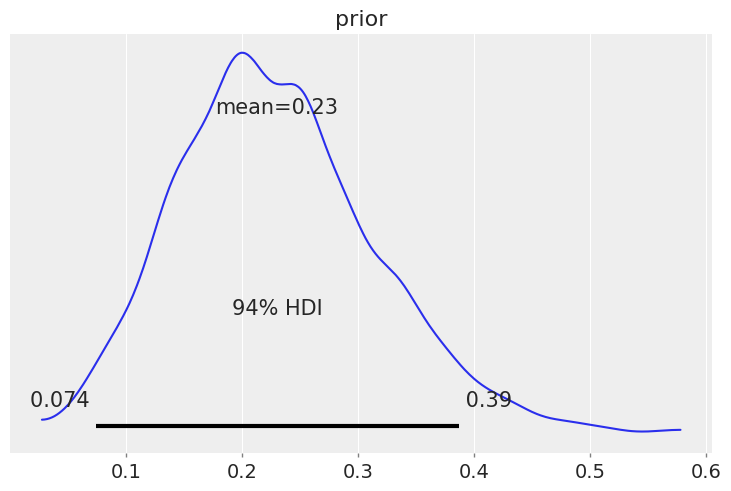

In [24]:
n1 = 20
k1 = 4

with pm.Model() as update_model:
  prior = pm.Beta("prior", alpha = 1, beta = 1)
  likelihood = pm.Binomial("likelihood", p = prior, n = n1, observed = k1)
  trace = pm.sample()

az.plot_posterior(trace)

Now we have two options.

* The first one is getting the distribution parameters after fitting the posterior distribution into a Beta distribution.

In [25]:
updated_alpha,updated_beta,_,_ = stats.beta.fit(p_values)
print(updated_alpha,updated_beta)

15.070813414603169 6.134814167171433


Output()

Output()

<Axes: title={'center': 'prior'}>

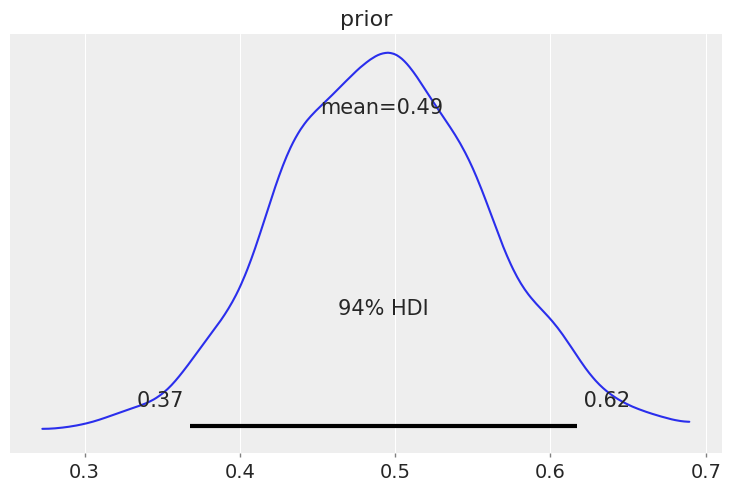

In [26]:
n2 = 30
k2 = 10

with pm.Model() as update_model:
  prior = pm.Beta("prior", alpha = updated_alpha, beta = updated_beta)
  likelihood = pm.Binomial("likelihood", p = prior, n = n2, observed = k2)
  trace = pm.sample()

az.plot_posterior(trace)

* The second one is generating a histogram from the posterior distribution and use x and y (density) values directly.


To get a more reliable distribution increase the accepted sample count. I didn't do that becuase it takes a long time.

 Ex:
```
 trace = pm.sample(target_accept = 1000)
 ```

Output()

Output()

ERROR:pymc.stats.convergence:There were 78 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: title={'center': 'prior'}>

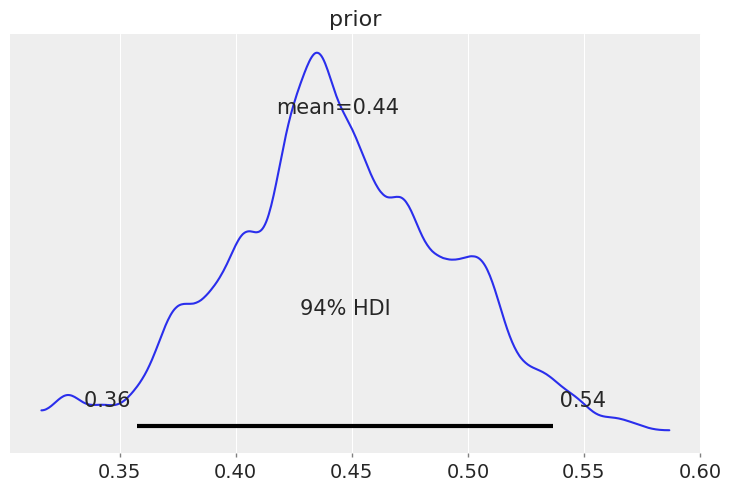

In [27]:
p_values = trace.posterior["prior"].values.flatten()
new_prior = np.histogram(p_values,bins = 100,density = True)

n2 = 30
k2 = 10

with pm.Model() as update_model:

  prior = pm.Interpolated(x_points = new_prior[1][1:],
                          pdf_points = new_prior[0],
                          name = "prior")
  likelihood = pm.Binomial("likelihood", p = prior, n = n2, observed = k2)
  trace = pm.sample()

az.plot_posterior(trace)

Note that since the number of x points are greater than the number of y points, we discarded the first point of x.

### 1.3.2. Normal - Normal Conjugate Family

Let's say our observations are `[10,9,10.5,11,10]`. Since they are continuous and the devation between the numbers is not too excessive, we can use a normal prior.

Output()

Output()

<Axes: title={'center': 'prior'}>

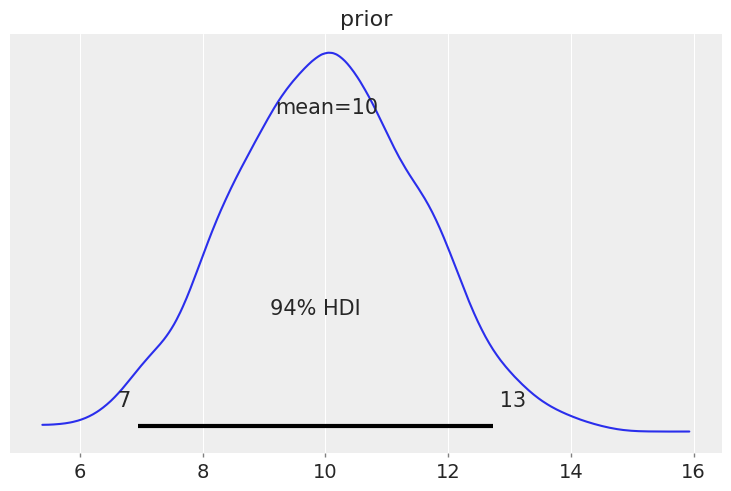

In [28]:
prior_mean = 10
prior_sd = 2

with pm.Model() as update_model:
  prior = pm.Normal("prior", mu = prior_mean, sigma = prior_sd)
  likelihood = pm.Normal("likelihood", mu = prior, sigma = 5, observed = [10,9,10.5,11,10])
  trace = pm.sample()

az.plot_posterior(trace)

* Again the first option is fitting the posterior into a Gaussian distribution, get the distribution parameters, and use them in the second iteration.

In [29]:
updated_mean,updated_sd = stats.norm.fit(trace.posterior["prior"].values.flatten())
print(updated_mean,updated_sd)

10.020707802183706 1.5583060925496166


Output()

Output()

<Axes: title={'center': 'prior2'}>

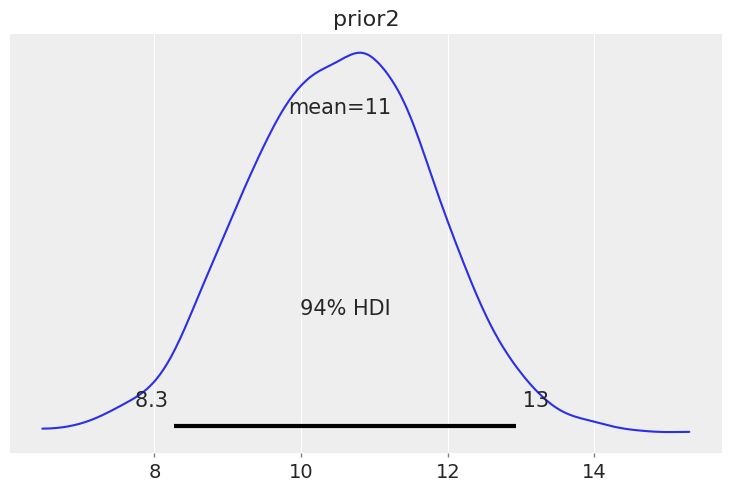

In [30]:
second_observation = [10,9,10.5,13,15]

with pm.Model() as update_model:
  new_prior_dist = pm.Normal("prior2",
                             mu = updated_mean,
                             sigma = updated_sd)

  likelihood = pm.Normal("likelihood", mu = new_prior_dist, sigma = 5, observed = second_observation)
  trace = pm.sample()

az.plot_posterior(trace)

* The second option is to create a histogram from the first posterior distribution, get the x and y values then use them in the second iteration.

To get a more reliable distribution increase the accepted sample count. I didn't do that becuase it takes a long time.

 Ex:
```
 trace = pm.sample(target_accept = 1000)
 ```

Output()

Output()

ERROR:pymc.stats.convergence:There were 55 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: title={'center': 'prior2'}>

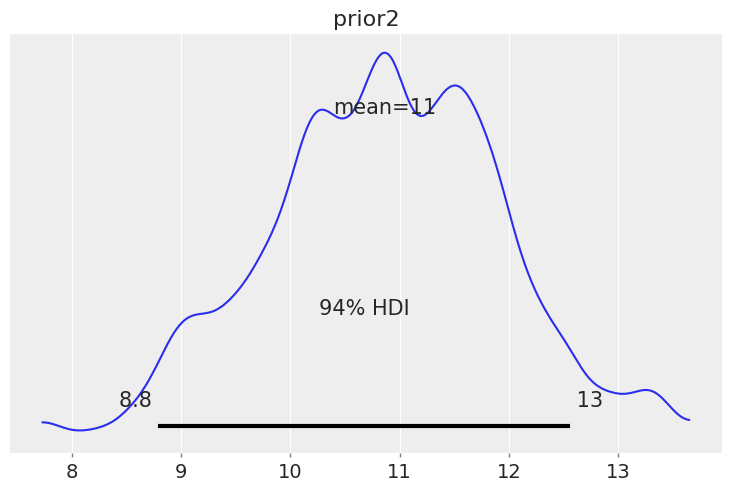

In [31]:
new_prior_values = trace.posterior["prior2"].values.flatten()
new_prior_dist_prep = np.histogram(new_prior_values,bins = 100,density = True)

with pm.Model() as update_model:
  new_prior_dist = pm.Interpolated(x_points = new_prior_dist_prep[1][1:],
                                 pdf_points = new_prior_dist_prep[0],
                                 name = "prior2")

  likelihood = pm.Normal("likelihood", mu = new_prior_dist, sigma = 5, observed = [10,9,10.5,13,15])
  trace = pm.sample()

az.plot_posterior(trace)

### 1.3.3. Gamma - Poisson Conjugate Family

Let's say we have a dataset consisting of 1000 data points and having an expectation of 0.75. We anticipate the expected frequency to be around 0.5 and to play safe, we look for a large deviation from our initial estimation. Then
`gamma-poisson` model would look like:

Output()

Output()

<Axes: title={'center': 'prior'}>

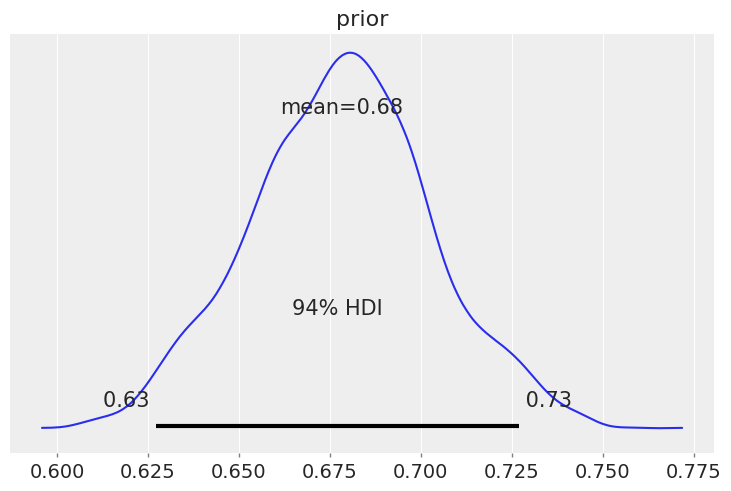

In [32]:
dataset1 = np.random.poisson(lam = 0.75,size = 1000)

mu1 = 0.5
sigma1 = 5

with pm.Model() as update_model5:
  prior = pm.Gamma("prior", mu = mu1, sigma = sigma1)
  likelihood = pm.Poisson("likelihood", mu = prior, observed = dataset1)
  trace = pm.sample()

az.plot_posterior(trace)

Then we obtained another dataset having 1000 data points and an expectation of 0.8:

To get a more reliable distribution increase the accepted sample count. I didn't do that becuase it takes a long time.

 Ex:
```
 trace = pm.sample(target_accept = 1000)
 ```

Output()

Output()

ERROR:pymc.stats.convergence:There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<Axes: title={'center': 'prior2'}>

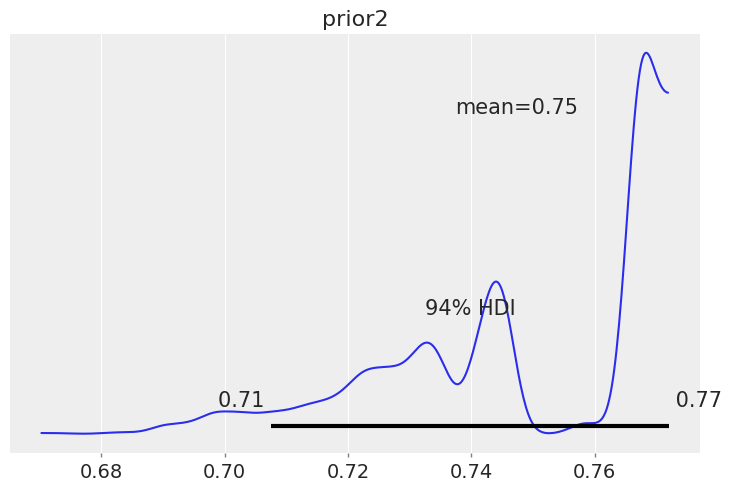

In [33]:
new_prior_dist_prep = np.histogram(trace.posterior["prior"].values.flatten(),bins = 100,density = True)
dataset2 = np.random.poisson(lam = 0.8,size = 1000)
with pm.Model() as update_model:
  new_prior_dist = pm.Interpolated(x_points = new_prior_dist_prep[1][1:],
                                 pdf_points = new_prior_dist_prep[0],
                                 name = "prior2")
  likelihood = pm.Poisson("likelihood", mu = new_prior_dist, observed = dataset2)
  trace = pm.sample(2000)

az.plot_posterior(trace)

# 2.Bayesian Modeling for Hypothesis Tests Using Markow Chain Monte Carlo (MCMC)

Sampling is much easier when the prior and posterior distributions are conjugate. However this is not possible all the time. In these cases Markov Chain Monte Carlo methods are used. Here is a great [video](https://www.youtube.com/watch?v=yApmR-c_hKU) explaining the concept.


Jeffreys-Zellner-Siow prior (JZS) is a type of Cauchy distribution having the parameters $C(0,r^2\sigma^2)$ and $p(\sigma^2) ∝ \frac 1 {\sigma^2}$. Generally $r$ is selected as 1 so the parameters reduce to $C(0,\sigma^2)$. In the [book](https://statswithr.github.io/book/), JZS prior is recommended if we have no reliable information. It has wide tails and therefore it is resilient to the prior misspesifications. We can't directly implement JZS prior in Python so I implemented it manually.

Let's make the exact example in the second reference (page 90) :

$\mu \sim   C(35,r^2\sigma^2)$

$ p(\sigma^2) \propto \frac {1} {\sigma^2}$

$ p(\sigma) \propto \frac {1} {\sigma} ; \sigma > 0$ (For derivation please refer this wikipedia [page](https://en.wikipedia.org/wiki/Jeffreys_prior))

$\mu|\sigma^2 \sim N(\mu,\sigma^2)$





Output()

Output()

<Axes: title={'center': 'mu'}>

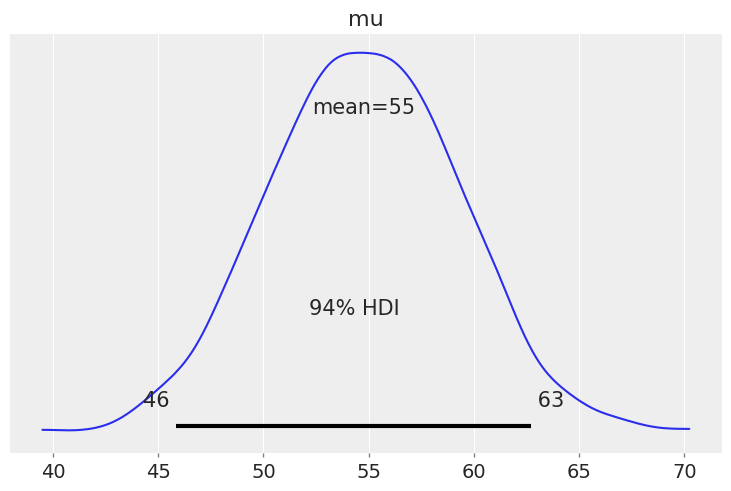

In [34]:
# same data used in the second reference. Page 90
data = np.array([ 34.38,  39.33, 108.63,  88.  ,  81.  ,  49.25,  75.  ,  82.86,
        85.  ,  86.6 ,  70.  ,  81.  ,  17.46,  50.  ,  70.5 ,  58.38,
        35.3 ,  45.  ,  53.  ,  38.75,  38.  ,  31.69,  49.  ,  34.  ,
        44.  ,  50.  ,  23.54,  35.  ])

r = 1
with pm.Model() as confidence_interval_model:

  sigma = pm.HalfFlat("sigma")
  pm.Potential("jeffrey", -pm.math.log(sigma))

  mu = pm.Cauchy("mu", 35, sigma* r**2)
  y = pm.Normal("y", mu = mu, sigma = sigma, observed = data)

  trace = pm.sample()

az.plot_posterior(trace.posterior["mu"])

In [35]:
data.mean()

55.52392857142858

Since we used JZS prior, we put more emphasis on the observations. Observation set averages at 55.5 and CI we got is not far from that value though we set $\mu_{prior} = 35$.

## 2.1. Hypothesis Testing on Paired Samples

When we are conducting hypothesis test over paired samples, we test whether the difference between the pairs are statistically significant or not. It is equivalent to state that the difference between means are 0 or not. Therefore:

* $H_0: \mu_{diff} = 0$
* $H_1: \mu_{diff} \neq 0$

Let's make the exact example in the second reference (page 99). I got the difference between the groups and stored it in `data` variable. Again we will use JZS prior.

$\mu \sim   C(0,r^2\sigma^2)$

$ p(\sigma^2) \propto \frac {1} {\sigma^2}$

$ p(\sigma) \propto \frac {1} {\sigma} ; \sigma > 0$

$\mu|\sigma^2,H_2 \sim N(\mu,\sigma^2)$

Output()

Output()

<Axes: title={'center': 'mu'}>

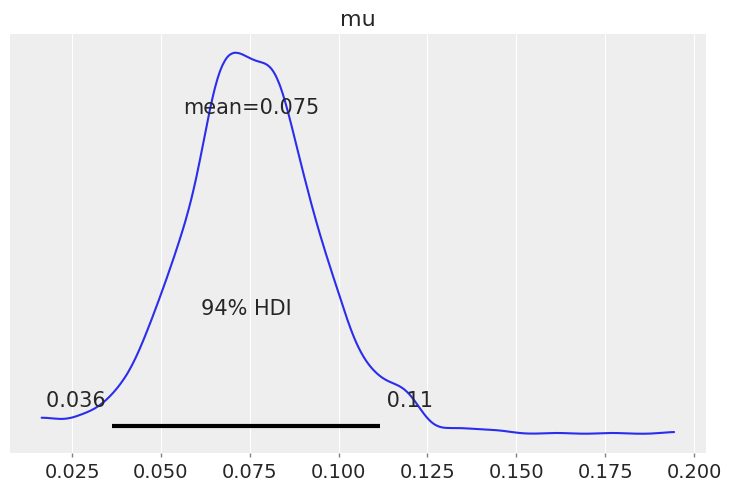

In [36]:
data = np.array([0.015, 0.028, 0.177, 0.121, 0.102, 0.107, 0.019, 0.066, 0.058,
       0.111])

r = 1
with pm.Model() as one_sample_model:
  sigma = pm.HalfFlat("sigma")
  pm.Potential("jeffrey",-pm.math.log(sigma))

  mu = pm.Cauchy("mu", alpha = 0, beta = sigma * r**2)

  likelihood = pm.Normal("likelihood",mu = mu,sigma = sigma,observed = data)

  trace = pm.sample()

az.plot_posterior(trace.posterior["mu"])

Since 0 not in the HDI, we reject $H_0$.

In [37]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.075,0.020,0.036,0.112,0.001,0.0,1033.0,844.0,1.0
sigma,0.059,0.016,0.036,0.089,0.001,0.0,1254.0,1013.0,1.0


## 2.2. Hypothesis Testing on Independent Samples



### 2.2.1. Question 1

The same question in $2^{nd}$ reference. (Page 104)

$δ = \frac {\alpha} {\sigma^2} \sim C(0,r^2)$

$young ∼ N(\mu+\alpha/2,\sigma^2)$

$mature ∼ N(\mu-\alpha/2,\sigma^2)$

$ p(\sigma^2) \propto \frac {1} {\sigma^2}$

$ p(\sigma) \propto \frac {1} {\sigma} ; \sigma > 0$

$H_0: \alpha = 0$

$H_1: \alpha \neq 0$

In [38]:
mature_mom = np.array([ 2., 20., 43., 30., 52., 15., 10., 30., 50., 29., 34., 22., 32.,
       35., 55., 20., 35., 20., 30., 30., 50., 30., 20., 18., 10.,  0.,
       20., 25., 13., 32., 24., 16., 15., 25., 29., 10., 31., 40., 13.,
       47., 28., 24., 20., 35., 50., 20., 20., 20., 11., 23., 40., 40.,
       43., 25.,  7., 37.,  2., 35., 17., 56., 25., 25., 40., 65., 25.,
       45., 45., 23., 30., 70., 20., 38., 29., 35., 35., 25., 18., 17.,
       10., 40., 29., 10., 36., 23., 30., 20., 40., 37., 45., 25., 44.,
       30., 65., 50., 13., 20., 37., 20., 35., 30., 34., 16., 30., 27.,
       40., 50., 25., 35., 24., 38., 29., 25., 27., 30., 15., 35., 23.,
       28., 61., 12., 10., 20., 40.,  0., 26., 20., 32., 25., 23.])

In [39]:
younger_mom = np.array([38., 20., 38., 34., 27., 22., 76., 15., 52., 28., 34., 12., 30.,
       75., 35.,  9., 12., 20., 39., 40., 38., 36., 20., 30., 30., 50.,
       68., 27., 22., 72., 25., 35., 10., 30., 25.,  1., 27., 30., 11.,
       50., 41., 20., 48., 35., 40., 30., 57., 28., 60., 10., 35., 18.,
       23., 26., 32., 56., 60., 28., 13., 23., 15., 47., 50., 17., 33.,
       25., 20.,  4., 10., 40., 22., 50., 16., 30.,  0., 23., 30., 35.,
       25., 46., 40., 36., 51., 55., 55., 25., 35., 35., 27., 38., 38.,
       36., 12., 48.,  0., 37., 47., 20., 20., 32.,  5., 50., 35., 24.,
       25., 30., 35., 35., 23., 30., 50., 19., 18., 46., 24., 35., 29.,
       18., 70., 35., 23., 20., 14., 35., 50., 60., 18., 40., 40., 27.,
       25., 22., 35., 28., 20., 10., 35., 25., 33., 31., 34., 52., 45.,
       52., 25., 25., 47., 19., 45., 45., 55., 41., 27., 55., 21., 24.,
       23., 39., 70., 26., 35., 30., 23., 20.,  6., 18., 32., 13., 40.,
       47., 40.,  2., 62., 18., 58., 25., 40., 26., 22., 28., 36., 17.,
       38., 32., 15., 40., 60., 13., 30., 35., 32., 27., 37., 30., 55.,
       26., 40., 30., 23., 12., 29.,  0., 30.,  0., 40., 41., 20., 56.,
       16., 25., 25., 65., 10., 13., 16., 31., 40., 15., 50., 21., 34.,
       24., 20., 32., 23., 11., 45., 32., 20., 45., 35.,  1., 31., 17.,
       15., 26., 32., 28., 10., 56., 23.,  9., 45., 35., 39., 31., 50.,
       80., 25., 29., 45., 85., 20., 30., 10., 37., 30., 23., 36., 41.,
       20., 19., 34., 30., 27., 18., 54., 50., 27., 38.,  0., 35., 30.,
       20., 35., 25., 10., 28., 11., 22., 23., 40., 30., 30., 29., 39.,
       30., 19., 36., 31., 25., 30., 12., 13.,  9., 20., 47.,  8.,  0.,
       35., 28., 24., 30., 35., 30., 33., 33., 30., 22., 54., 55., 56.,
       25., 40., 40., 60., 62., 50., 28., 30., 15., 30., 20., 30., 27.,
       23., 30., 35., 35., 40., 20., 10., 40., 15., 36.,  8., 58., 45.,
       30., 41., 10., 20., 50., 20., 35., 18., 15., 30., 28., 60., 13.,
       35., 35., 37., 46., 58.,  0., 26., 21., 20., 29., 28., 70., 29.,
       50., 30., 40., 23., 34., 47., 22., 12., 31., 13., 18., 30., 31.,
       27.,  0., 35., 38., 20., 20., 50., 50., 38., 20., 53., 36., 20.,
       25., 28., 34., 48., 27., 60., 47., 18., 31., 30., 26., 40., 33.,
       31., 50., 32., 29., 33., 35., 13., 41., 20., 32., 13., 24., 26.,
       25., 44., 37., 33., 30., 35., 23., 18., 30.,  0., 20., 40., 40.,
       32., 45., 21., 27., 43., 30., 25., 27., 35., 55., 40., 35., 27.,
       38., 38., 29., 38., 38., 30., 25.,  0., 68., 24., 35., 20., 19.,
       39., 40., 20., 20., 40., 15., 23., 37., 22., 55., 36., 40., 43.,
       25., 38., 31., 30., 65., 40., 10., 21., 13., 48., 19.,  0., 28.,
       58., 20., 36., 61., 50., 31., 38., 14., 15., 37., 15.,  3., 17.,
       35., 40., 43., 21., 29., 18., 40., 48., 25., 20., 50., 37., 10.,
       30., 24., 22., 31., 34., 12., 40., 24., 58., 42., 23.,  5., 22.,
       38., 30., 30., 20., 19., 14., 18.,  0., 32., 40., 31., 21., 35.,
       47., 45., 28.,  0.,  0., 72., 35., 39.,  0., 13., 35., 14., 43.,
       33., 20., 20., 19., 24., 18., 35., 35., 16., 35., 20., 34., 33.,
       25., 32., 20., 30., 70., 41., 34., 25., 35., 18., 14., 40., 25.,
       40., 25., 40., 35., 30., 20., 30., 20., 38., 26.,  0., 30., 30.,
       20., 30., 29., 50., 25., 45., 17., 36., 39., 30., 25., 30., 35.,
       28., 25., 55., 40., 15., 34., 23., 20., 30., 51., 30., 14., 55.,
       12., 25., 24., 20., 35., 40., 20., 30., 33., 45., 13., 50., 25.,
       15., 20., 30., 25., 40., 25., 19., 57., 29., 40., 22., 27., 25.,
       47., 28., 59., 47., 40., 45., 23., 35., 21., 35., 38., 43., 30.,
        0., 30., 30., 50., 42., 20.,  1., 44., 17., 19., 30., 30., 21.,
       14., 20.,  0., 22., 45., 26., 44., 54., 38., 44., 40., 33., 34.,
       46.,  3., 41., 35., 28., 44., 34., 12., 20., 19., 40., 50., 37.,
       35., 50., 30., 34., 14., 33., 25., 32., 45., 42., 30., 35., 29.,
       30., 22., 85., 37., 30., 56., 20., 55.,  7., 20., 20., 31., 34.,
       55., 42., 25., 28., 30., 55., 21., 20., 43., 25., 32., 22., 26.,
       30., 27., 28., 22., 10., 29., 42., 20., 45., 24., 22., 25., 48.,
       25., 16., 37., 35., 27., 30., 35., 30., 22., 29., 36., 35., 60.,
       10., 23., 15., 60.,  3., 35., 26., 20., 15., 28., 25.,  0., 41.,
       44.,  0., 20., 17., 40., 24.,  6., 18., 21., 24., 30.,  0., 41.,
       30.,  0., 35., 23., 36., 40.,  0., 30., 18., 35., 25., 77., 45.,
       60., 30.,  0., 25., 20., 23., 15., 33., 35., 30., 35., 75., 20.,
       32., 60., 42., 30., 23., 40., 36., 34.,  0., 30., 40., 15., 25.,
       25., 36., 20., 25., 28., 23., 20., 57.,  0., 40., 35., 28., 22.,
       15., 38., 33., 40., 44., 60., 34., 29., 22., 15., 14., 21.])

In [40]:
r = 1
with pm.Model() as independent_hypothesis_model:

  mu = pm.Flat('mu')

  sigma = pm.HalfFlat("sigma")
  pm.Potential("jeffrey", -pm.math.log(sigma))

  delta = pm.Cauchy("delta", alpha = 0,beta =r**2)
  alpha = delta * sigma**2

  mu_young = mu - alpha/2
  mu_mature = mu + alpha/2

  likelihood_young = pm.Normal("young", mu_young, sigma, observed = younger_mom)
  likelihood_mature = pm.Normal("old", mu_mature, sigma, observed = mature_mom)

  diff_of_means = pm.Deterministic("diff_of_means", mu_mature-mu_young)
  trace = pm.sample()

Output()

Output()

<Axes: title={'center': 'diff_of_means'}>

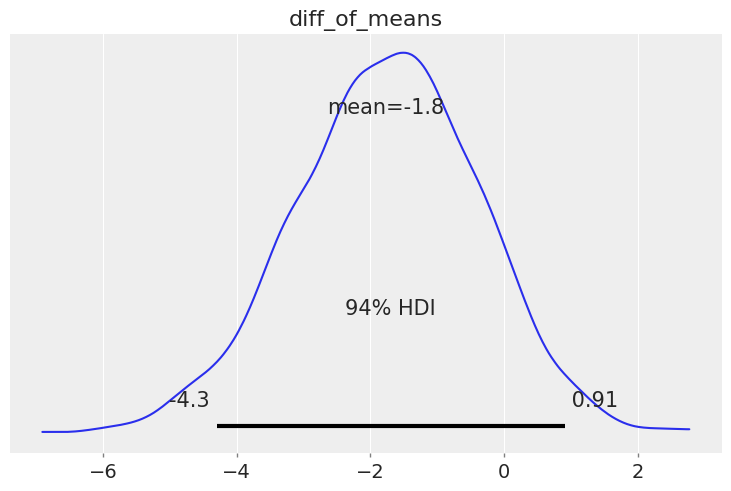

In [41]:
pm.plot_posterior(trace.posterior["diff_of_means"])

Since 0 in the posterior difference distribution, we can not say that two groups are different from each other.

### 2.2.2. Question 2

The same question in $2^{nd}$ reference. (Page 107)

$δ = \frac {\alpha} {\sigma^2} \sim C(0,r^2)$

$young ∼ N(\mu+\alpha/2,\sigma^2)$

$mature ∼ N(\mu-\alpha/2,\sigma^2)$


$ p(\sigma^2) \propto \frac {1} {\sigma^2}$

$ p(\sigma) \propto \frac {1} {\sigma} ; \sigma > 0$

$H_0: \alpha = 0$

$H_1: \alpha \neq 0$

In [42]:
smokers = np.array([7.56, 6.88, 5.81, 7.44, 7.06, 8.06, 7.44, 7.88, 6.19, 1.69, 6.75,
       6.94, 8.38, 7.31, 7.94, 8.38, 6.19, 8.25, 6.69, 5.25, 6.31, 7.5 ,
       7.44, 9.06, 7.38, 5.38, 4.13, 2.69, 7.69, 7.44, 6.38, 9.13, 8.31,
       5.06, 8.63, 5.5 , 6.25, 7.81, 6.63, 6.88, 6.94, 6.  , 7.81, 6.38,
       8.38, 6.31, 7.13, 6.5 , 8.13, 7.31, 5.75, 7.31, 7.5 , 7.06, 5.75,
       6.13, 7.19, 8.13, 6.88, 7.38, 7.13, 7.5 , 5.  , 5.81, 6.  , 7.31,
       9.06, 5.94, 6.5 , 7.13, 4.5 , 8.  , 7.31, 9.13, 7.13, 7.31, 7.38,
       7.75, 7.25, 6.25, 8.88, 8.56, 6.75, 7.56, 7.81, 8.38, 7.  , 4.75,
       8.25, 7.44, 7.  , 7.94, 4.06, 3.31, 7.69, 5.69, 8.69, 4.88, 5.94,
       7.81, 6.5 , 6.88, 6.38, 6.  , 6.5 , 9.19, 6.  , 7.06, 8.13, 4.75,
       5.94, 4.44, 8.19, 9.13, 6.31, 6.44, 5.63, 7.06, 5.38, 6.88, 7.5 ,
       8.19, 2.19, 6.06, 6.75, 5.5])

In [43]:
nonsmokers = np.array([7.63,  7.88,  6.63,  8.  ,  6.38,  5.38,  8.44,  4.69,  8.81,
        6.94,  7.44,  8.81,  6.  ,  7.13,  1.5 ,  8.25,  6.19,  7.  ,
        7.19,  6.  ,  7.63,  9.5 ,  5.56,  7.5 ,  7.44,  7.56,  6.06,
        7.  ,  4.56,  2.63,  6.38,  7.25,  1.56,  7.44,  6.  ,  6.5 ,
        7.31,  7.88,  6.19,  7.  ,  5.81,  7.44,  7.75,  8.  ,  6.63,
        8.31,  7.25,  5.5 ,  7.81,  7.  ,  7.31,  9.06,  6.56,  5.88,
        6.63,  9.06,  8.75,  7.06,  6.88,  5.94,  8.56,  6.19,  4.44,
        4.75,  5.5 ,  7.88,  7.5 ,  7.88,  5.94,  8.56,  9.25,  7.69,
        5.94,  9.5 ,  6.06,  6.94,  8.19,  6.75,  6.25,  8.  ,  8.31,
        7.75,  4.69,  5.38,  8.38,  6.88,  2.88,  5.88,  1.38,  6.5 ,
        6.31,  5.25,  7.25,  9.94,  7.31,  5.63,  6.5 ,  5.63,  6.31,
        9.56,  5.44,  6.75,  8.38,  7.19,  7.19,  6.06,  7.19,  5.94,
        8.56,  6.69,  7.5 ,  7.44,  7.88,  8.75,  7.44,  7.44,  6.38,
        8.81,  7.  ,  7.19,  5.94,  6.75,  8.13,  6.38,  7.13,  6.88,
        8.44,  8.31,  7.25,  6.06,  5.75,  6.75,  8.06,  9.  ,  6.25,
        7.06,  8.  ,  8.31,  7.75,  7.44,  8.44,  6.94,  4.5 ,  6.38,
        7.63,  4.5 ,  4.94,  6.13,  7.75,  8.38,  6.81,  6.  ,  9.56,
        7.56,  7.44,  7.38,  5.94,  7.  ,  6.94,  6.94,  6.38,  7.19,
        7.63,  8.38,  7.5 ,  7.88,  7.63,  7.75,  5.44,  6.5 ,  8.06,
        6.75,  8.19,  5.88,  8.06,  6.88,  9.06,  7.13,  8.13,  6.75,
        7.88,  7.69,  5.44,  5.81,  4.25,  9.88,  6.81,  2.5 ,  5.94,
        7.56,  4.63,  7.25,  6.5 ,  8.19,  6.75,  8.  ,  8.38,  8.25,
        6.88,  7.5 ,  7.5 ,  8.44,  7.94,  9.  ,  7.5 ,  7.69,  7.19,
        7.25,  7.44,  7.69,  7.81,  6.69,  5.44,  7.  ,  7.69, 10.19,
        7.25,  9.  ,  5.88,  7.06,  7.5 ,  8.56,  7.38,  7.19,  6.  ,
        5.81,  8.  ,  6.38,  7.19,  8.38,  8.44,  7.31,  7.31,  5.  ,
        4.69,  3.75,  5.88,  2.69,  1.  ,  7.19,  8.88,  8.81,  6.75,
        6.81,  6.44,  9.88,  6.88,  8.75,  6.69,  7.88,  5.88,  9.  ,
        7.75,  6.06,  7.  ,  5.38,  7.31,  8.44,  7.63,  8.44,  6.88,
        8.38,  8.38,  7.63,  7.81,  8.19,  7.31,  7.5 ,  7.25,  7.13,
        7.81,  8.69,  1.19,  5.88,  9.25,  6.25,  1.44,  8.56,  5.13,
        5.44,  6.69,  5.5 ,  6.44,  5.88,  7.25,  8.19,  5.94,  7.13,
        6.69, 10.06,  7.81,  6.31,  8.19,  7.31,  7.63,  7.69,  9.  ,
        5.88,  7.13,  8.75,  6.5 ,  8.38,  3.75,  7.44,  9.13,  7.31,
        6.31,  6.25,  8.5 ,  8.31,  6.56,  7.13,  5.94,  7.5 ,  7.19,
        6.88,  6.63,  7.06,  7.19,  6.94,  7.81,  8.5 ,  7.25,  8.5 ,
        5.81,  7.5 ,  8.13,  5.06,  7.38,  6.25,  8.75,  6.94,  8.13,
        8.25,  8.  ,  6.31,  7.75,  7.75,  7.06,  7.88,  7.69,  7.94,
        6.88,  6.75,  7.94,  8.75,  8.56,  7.38,  3.94,  8.75,  8.19,
        9.19,  6.06,  7.44,  7.38,  8.06,  7.56,  6.88,  7.75,  7.63,
        9.38,  8.31,  7.63,  6.88,  5.63,  8.38,  9.  ,  8.75,  7.94,
        7.  ,  6.75,  5.19,  1.69,  6.13,  6.88,  7.19,  5.94,  9.  ,
        7.25,  7.19,  6.94,  7.13,  7.56,  8.25,  8.38,  6.75,  5.38,
        7.13,  8.75,  7.75,  8.44,  8.  ,  8.19,  7.94,  7.38,  9.31,
        8.88,  8.06,  7.06,  6.56,  8.19,  8.31,  5.88,  7.44,  7.44,
        6.75,  7.44,  7.5 ,  6.56,  7.  ,  7.69,  8.  ,  2.25,  8.19,
        3.44,  6.5 ,  4.  ,  7.5 ,  8.  ,  8.  ,  6.63,  6.75,  7.44,
        6.25,  6.56,  5.63,  4.56,  8.5 ,  8.88,  6.25,  7.06,  7.94,
        6.31,  9.06,  9.13,  7.06,  8.25,  7.75,  8.25,  5.75,  7.69,
        6.69,  7.75,  6.81,  8.  ,  6.56,  9.63,  8.25,  7.56,  7.19,
        7.69,  1.38,  4.06,  7.38,  5.56,  7.44,  6.75,  8.38,  7.81,
        8.13,  8.06,  7.38,  9.25,  7.63,  8.38,  7.5 ,  8.  ,  8.13,
        7.31,  7.56,  7.44,  7.06,  7.5 ,  7.25,  8.56,  7.94,  8.13,
        7.06,  6.44,  5.81,  8.44,  6.44,  7.56,  8.25,  6.38,  7.13,
        5.56,  6.88,  7.75,  7.25,  7.75,  8.13,  8.19,  8.5 ,  5.69,
        6.38,  1.88,  3.56,  6.25,  3.19,  7.31,  6.13,  7.38,  7.88,
        8.94,  8.06,  7.69,  8.56,  7.13,  9.81,  6.81,  8.31,  8.44,
        6.94,  8.5 ,  7.88,  7.94,  7.  ,  7.81,  5.38,  6.25,  6.19,
        7.88,  6.5 ,  7.  ,  7.13,  7.69,  9.56,  6.5 ,  7.44,  6.31,
        8.5 ,  7.31,  5.  ,  5.44,  6.81,  6.31,  9.75,  8.25,  6.63,
        7.56,  7.81,  6.81,  5.44,  7.94,  7.38,  1.  ,  6.  ,  6.  ,
        8.25,  6.06,  6.56,  8.19,  8.63,  6.75,  8.13,  5.81,  9.75,
        7.63,  4.56,  8.75,  7.13,  7.31,  5.63,  8.44,  7.88,  7.25,
       11.75,  6.88,  7.5 ,  6.88,  7.63,  8.38,  7.56,  7.25,  4.19,
        7.06,  6.06,  2.94,  6.  ,  5.5 ,  8.69,  8.  ,  6.81,  6.56,
        9.19,  9.19,  7.44,  7.38,  7.81,  7.81,  7.88,  8.  ,  6.56,
        6.13,  7.44,  7.63,  7.5 ,  6.31,  5.25,  4.75,  7.25,  8.13,
        9.25,  8.06,  6.63,  7.13,  6.38,  9.5 ,  7.13,  8.81,  7.88,
        6.25,  8.  ,  7.88, 10.38,  8.81,  6.5 ,  7.  ,  8.19,  7.63,
        7.19,  7.06,  1.31,  2.88,  6.  ,  5.94,  5.25,  7.19,  4.75,
        6.13,  9.38,  7.13,  7.38,  7.44,  5.81,  9.13,  6.25,  8.5 ,
       11.63,  6.75,  5.56,  6.  ,  6.69,  9.5 ,  8.88,  9.19,  9.31,
        7.38,  8.88,  6.19,  8.81,  7.31,  7.38,  5.  ,  9.25,  6.69,
        6.81,  3.  ,  4.63,  5.56,  4.44,  1.44,  1.5 ,  5.06,  6.81,
        8.81,  6.56,  6.75,  7.94,  7.31,  6.44,  3.94,  8.06,  9.25,
        7.38,  7.38,  7.56,  8.81,  6.  ,  6.88,  8.06,  6.69,  7.06,
        6.88,  9.63,  7.88,  8.88,  7.81,  7.38,  7.5 ,  7.31,  8.25,
        6.56,  8.81,  7.88,  8.31,  5.88,  8.63,  9.31,  7.88,  9.63,
       10.06,  7.13,  6.81,  5.63,  6.56,  7.13,  8.19,  8.  ,  8.63,
        6.69,  6.38,  8.5 ,  6.81,  7.88,  7.56,  7.25,  6.88,  8.5 ,
        8.5 ,  4.75,  8.75,  6.44,  7.  ,  7.25,  8.25,  8.5 ,  7.44,
        7.75,  8.5 ,  8.13,  6.94,  7.25,  9.69,  6.31,  6.75,  6.88,
        8.75,  9.31,  7.88,  7.63,  8.31,  7.88,  7.56,  6.19,  7.94,
        7.19,  6.31,  4.69,  3.81,  2.88, 10.13,  7.06,  8.56,  6.94,
        8.81,  8.44,  8.13,  7.63,  8.44,  8.88,  8.25,  7.88,  7.31,
        7.88,  7.5 ,  5.19,  8.06,  8.94,  7.69,  6.63,  7.63,  7.56,
        6.38,  6.25,  7.13,  7.94,  6.5 ,  6.44,  8.69,  5.63,  2.25,
        6.75,  1.63,  8.88,  7.06,  8.81,  7.56,  9.19,  6.19,  5.38,
        7.19,  6.75,  7.38,  6.06,  6.88,  7.  ,  8.56,  8.19,  7.  ,
        8.13,  9.13,  7.81,  7.  ,  8.25,  8.  , 10.25,  7.69,  7.06,
        3.25,  4.  ,  4.13,  5.13,  9.88,  6.19,  7.81,  8.75,  9.31,
        7.  ,  6.69,  8.63,  8.5 ,  8.94,  6.31,  7.25,  7.  ,  7.94,
        6.25,  7.94,  8.31,  8.5 ,  8.38,  4.94,  5.94,  4.31,  3.63,
        8.75,  7.  ,  6.25,  8.94,  8.38,  7.56,  7.75,  7.25, 10.13,
        1.38,  5.5 ,  8.06,  7.81,  7.5 ,  7.19,  7.31,  9.88,  9.19,
        8.13,  9.  ,  7.44,  5.69,  7.81,  6.69,  6.38,  7.44,  5.88,
        7.69,  7.56,  6.56,  5.69,  8.44,  6.19,  6.94,  4.56,  7.13])

Output()

Output()

<Axes: title={'center': 'diff_of_means'}>

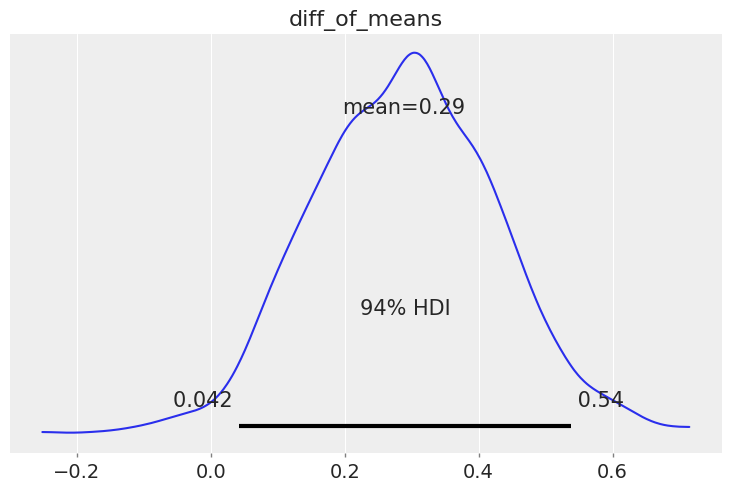

In [44]:
r = 0.5
with pm.Model() as independent_hypothesis_model2:

  sigma = pm.HalfFlat("sigma")
  pm.Potential("jeffrey", -pm.math.log(sigma))

  mu = pm.Flat('mu')
  delta = pm.Cauchy("delta", alpha = 0,beta =r**2)
  alpha = delta * sigma**2

  mu_smokers = mu - alpha/2
  mu_nonsmokers = mu + alpha/2

  likelihood_smokers = pm.Normal("smokers", mu_smokers, sigma, observed = smokers)
  likelihood_nonsmokers = pm.Normal("nonsmokers", mu_nonsmokers, sigma, observed = nonsmokers)

  diff_of_means = pm.Deterministic("diff_of_means", mu_nonsmokers-mu_smokers)
  trace = pm.sample()

az.plot_posterior(trace.posterior["diff_of_means"])

We can say that two groups are most likely to be different from each other.

# 3.Linear Regression

In this section, we will build OLS and Bayesian Linear Regression then discuss about when to use which by looking at the results.

## 3.1. Frequentist Approach for Linear Regression - Ordinary Least Squares (OLS)

Given the data, OLS models the data $X$ and the response variable $y$ as:

$y = X\hat{β} + ϵ$

$\hat{β} = (X^TX)^{-1}X^Ty$

$ϵ ∼ N(0,σ^2)$

This model work perfectly when the data points are normally distributed around mean and there are no outlier points. Moreover, it is supported by many libraries. Let's see how to fit a OLS model to a dataset:

### 3.1.1. Perfect Fit

The synthetic data:

$X \sim N(5,1)$

$ϵ ∼ N(0,1)$

$y = 2X + ϵ$

In [45]:
np.random.seed(42)
X = np.random.normal(loc = 5, scale = 1,size = 100)
error = np.random.normal(loc = 0, scale = 1,size = 100)
y = 2*X + error

model = sm.OLS(y,sm.add_constant(X)).fit()

<ipython-input-46-0de395c092a7>:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


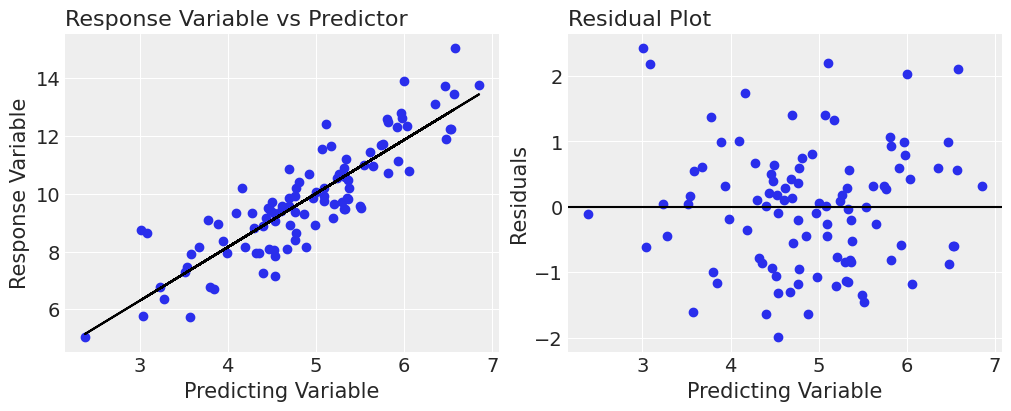

In [46]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,4))

ax[0].set_xlabel("Predicting Variable")
ax[0].set_ylabel("Response Variable")
ax[0].set_title("Response Variable vs Predictor",loc = 'left')
ax[0].plot(X, model.predict(sm.add_constant(X)), color = "black")
ax[0].scatter(X, y)

ax[1].scatter(X, model.resid)
ax[1].axhline(y = 0, color = "black")
ax[1].set_xlabel("Predicting Variable")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residual Plot",loc = 'left')

fig.tight_layout()
fig.show()

The data points are normally distributed around mean and residuals normally distributed around 0. .

### 3.1.2. Imperfect Fit

This time, I will intentionally added outlier terms to the *same* dataset. Let's see how the model behaves.

In [47]:
np.random.seed(42)
X = np.random.normal(loc = 5, scale = 1,size = 100)
error = np.random.normal(loc = 0, scale = 1,size = 100)
y = 2*X + error

outlier_X = np.array([15,16,17])
outlier_y = outlier_X *4 + 20

X = np.concatenate((X,outlier_X))
y = np.concatenate((y,outlier_y))

df = pd.DataFrame({"Independent_Variable":X,"Response_Variable":y})
model = sm.OLS(y,sm.add_constant(X)).fit()

<ipython-input-48-0de395c092a7>:15: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


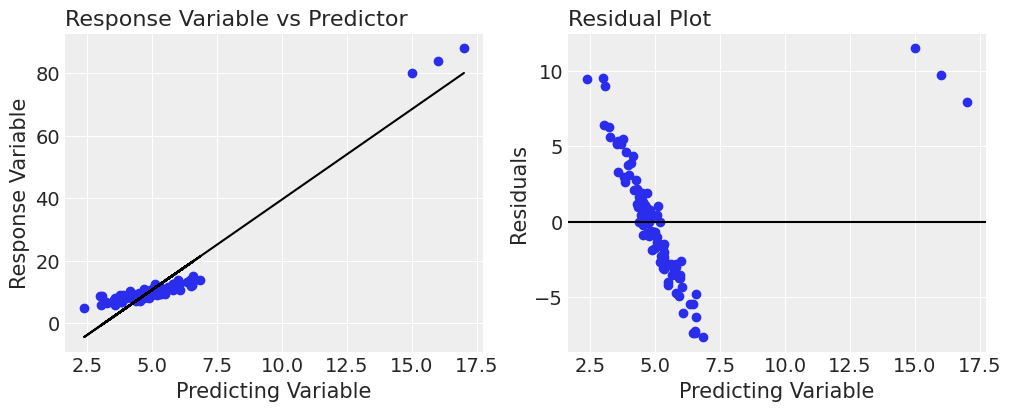

In [48]:
fig,ax = plt.subplots(ncols = 2,figsize = (10,4))

ax[0].set_xlabel("Predicting Variable")
ax[0].set_ylabel("Response Variable")
ax[0].set_title("Response Variable vs Predictor",loc = 'left')
ax[0].plot(X, model.predict(sm.add_constant(X)), color = "black")
ax[0].scatter(X, y)

ax[1].scatter(X, model.resid)
ax[1].axhline(y = 0, color = "black")
ax[1].set_xlabel("Predicting Variable")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residual Plot",loc = 'left')

fig.tight_layout()
fig.show()

The outlier terms changed the slope of the regression line significantly. When there are outlier terms and they are far from the rest of the data, their impact on the regression model becomes significant.

Let's look at the prediction interval as well.

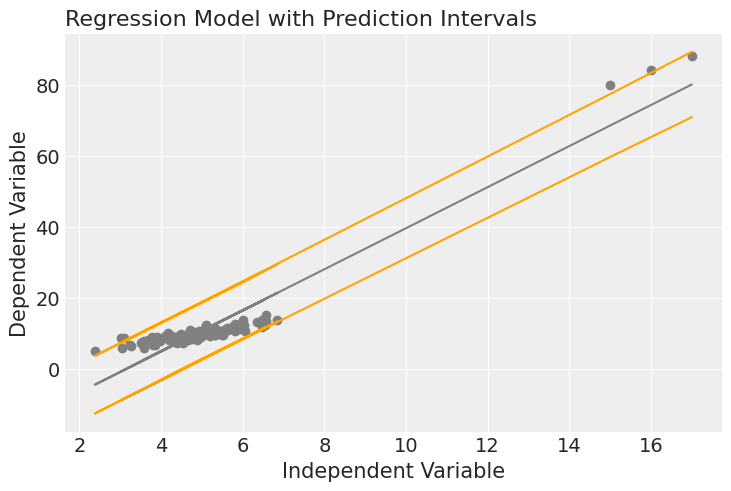

In [49]:
prediction = model.get_prediction(sm.add_constant(X))
prediction_frame = prediction.summary_frame(alpha = 0.05)

plt.figure()
plt.scatter(X, y, color='grey', label='Data')
plt.plot(X, prediction_frame['mean'], color='grey')
plt.plot(X, prediction_frame['obs_ci_lower'], color = 'orange')
plt.plot(X, prediction_frame['obs_ci_upper'], color = 'orange')
plt.title("Regression Model with Prediction Intervals",loc = 'left')
plt.xlabel("Independent Variable")
plt.ylabel("Dependent Variable")
plt.show()

Even the prediction interval can not fully catch the location of the outlier points. Depending on the problem, we can discard these outlier points and construct the model again. However, we can't do this all the time. Many times these points contain valuable information. This is when Bayesian Linear Regression could be useful. In any case, the OLS solution minimizes the squared loss. However as you can see, it may not always our intention. When there are outlier points, minizing mean absolute error may be more valuable.

In [50]:
print("Mean Square Error (OLS):",model.mse_resid)
print("Mean Absolute Error (OLS):", mean_absolute_error(model.predict(sm.add_constant(X)),y))

Mean Square Error (OLS): 16.267811531561783
Mean Absolute Error (OLS): 3.1255083330316067


## 3.2. Bayesian Linear Regression

For Bayesian Linear Regression we will use `Bambi` module. To make the model more robust, I chose `t-distribution` for fitting. The model:

$y = Xβ + ϵ$

$ϵ ∼ StudentT(0, \sigma^2,\nu)$

$\sigma ∼ HalfCauchy(0,3)$

$\nu ∼ Exponential(\lambda = 1)$

In [51]:
!pip install bambi
import bambi as bmb

Output()

Output()

array([<Axes: title={'center': 'Independent_Variable'}>,
       <Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'nu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

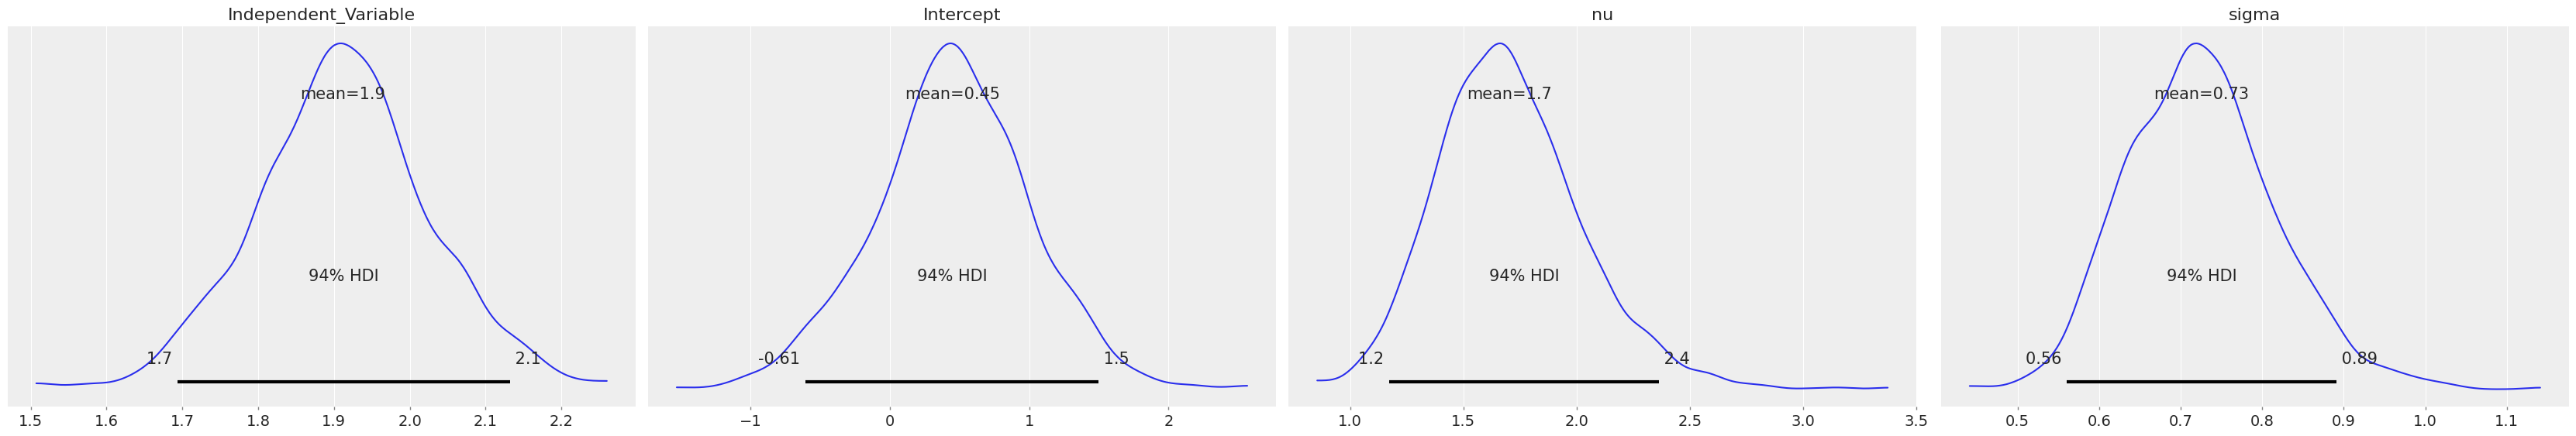

In [52]:
priors = {
    "σ": bmb.Prior("HalfCauchy", sigma=3),
    "ν": bmb.Prior("Exponential", lam=1)
}

bayes_model = bmb.Model("Response_Variable ~ Independent_Variable",
                        data=df,
                        family="t",
                        priors=priors)
inference = bayes_model.fit()
az.plot_posterior(inference)

As you can see, the mean (1.9) is far closer to the real coefficient that I used (2) while I was creating the dataset. Let's plot the model and data on a figure.

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


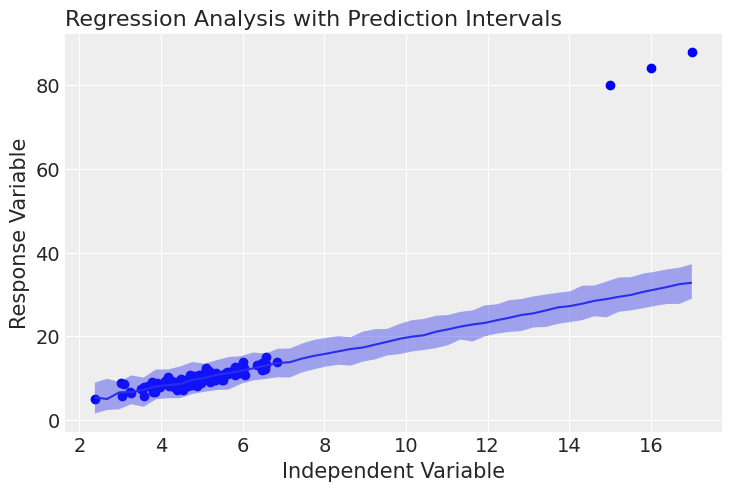

In [53]:
fig,ax = plt.subplots()
ax.scatter(X, y, color='blue')
bmb.interpret.plot_predictions(bayes_model,inference,["Independent_Variable"],ax=ax,pps = True)
plt.xlabel('Independent Variable')
plt.ylabel('Response Variable')
plt.title('Regression Analysis with Prediction Intervals',loc = 'left')
plt.show()

In [54]:
az.summary(inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Independent_Variable,1.911,0.114,1.694,2.132,0.003,0.002,1643.0,1330.0,1.0
Intercept,0.446,0.559,-0.609,1.497,0.013,0.010,1792.0,1352.0,1.0
nu,1.702,0.321,1.172,2.364,0.007,0.005,2034.0,1729.0,1.0
sigma,0.725,0.091,0.560,0.891,0.002,0.002,1851.0,1510.0,1.0


Our model is robust. It did not affected by the outlier points. Let's see the prediction errors:

In [55]:
intercept = inference.posterior["Intercept"].values.flatten().mean()
coef = inference.posterior["Independent_Variable"].values.flatten().mean()

predictions = coef*X + intercept
mse = mean_squared_error(y, predictions)
print("Mean Squared Error (Bayesian):", mse)
print("Mean Absolute Error (Bayesian):", mean_absolute_error(y,predictions))

Mean Squared Error (Bayesian): 82.67773172657495
Mean Absolute Error (Bayesian): 2.2719782223030456


As I said before the mean absolute error is higher. However since we know that the data contains many outlier data points, mean absolute error would be a wiser evaluation metric. The Bayesian model performs better in that regard.

### 3.2.1. Bayesian Update in Linear Regression

Let's say we achieved a new set of data. This time we will use the posterior probabilies that we obtained from the first model.

In [56]:
np.random.seed(56)
X2 = np.random.normal(loc = 5, scale = 1,size = 100)
error = np.random.normal(loc = 0, scale = 1,size = 100)
y2 = 2*X2 + error

df2 = pd.DataFrame({"Independent_Variable":X2,"Response_Variable":y2})
posterior_samples = inference.posterior["Independent_Variable"].values.flatten()
priors = {"x": pm.DensityDist.dist(posterior_samples)}

updated_bayes_model = bmb.Model("Response_Variable ~ Independent_Variable",
                        data=df2,
                        priors = priors,
                        family = "t")
updated_inference = updated_bayes_model.fit()

Output()

Output()

array([<Axes: title={'center': 'Independent_Variable'}>,
       <Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'nu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

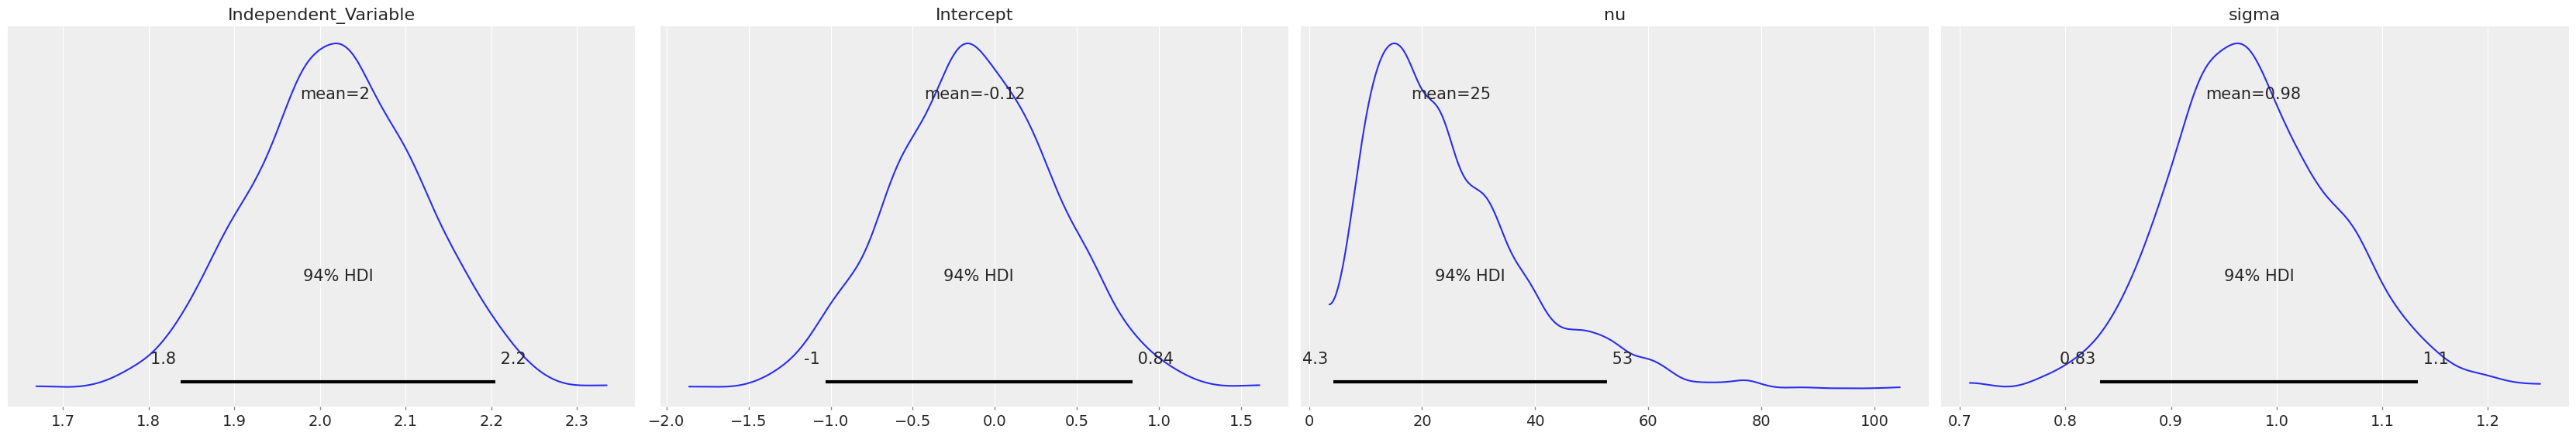

In [57]:
az.plot_posterior(updated_inference)

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


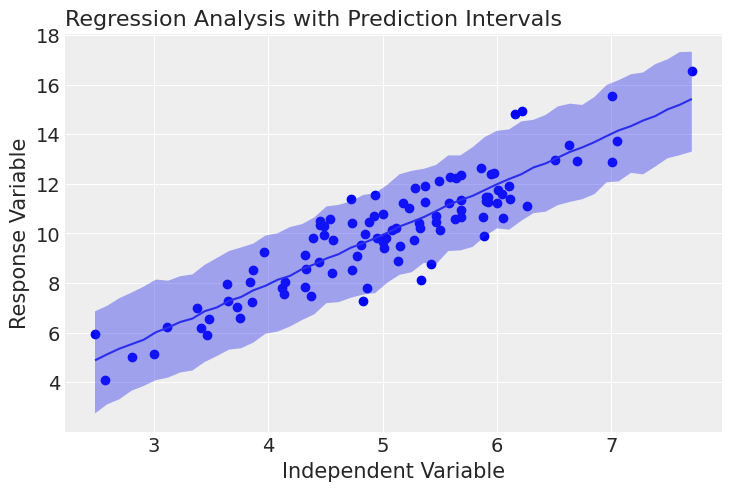

In [58]:
fig,ax = plt.subplots()
ax.scatter(X2, y2, color='blue')
bmb.interpret.plot_predictions(updated_bayes_model,updated_inference,["Independent_Variable"],ax=ax,pps = True)
plt.xlabel('Independent Variable')
plt.ylabel('Response Variable')
plt.title('Regression Analysis with Prediction Intervals',loc = 'left')
plt.show()

In [59]:
intercept2 = updated_inference.posterior["Intercept"].values.flatten().mean()
coef2 = updated_inference.posterior["Independent_Variable"].values.flatten().mean()

predictions2 = coef2*X2 + intercept2
mse2 = mean_squared_error(y2, predictions2)
print("Mean Squared Error (Bayesian):", mse2)
print("Mean Absolute Error (Bayesian):", mean_absolute_error(y2,predictions2))

Mean Squared Error (Bayesian): 1.0034274603542073
Mean Absolute Error (Bayesian): 0.8054185334240017


That's the end of this tutorial. Thanks for following...